In [66]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import umap

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

from data.load_data import load_data_1D_impute

In [67]:
feature_type = "Griffin"
input_size = 2600
data_path = "/mnt/binf/eric/CCSA_test/"
output_path = "/mnt/binf/eric/CCSA_test/feature_visualization_CCSA/"

train_info = pd.read_pickle(
    "/mnt/binf/eric/Mercury_Dec2023/Feature_all_Apr2024_frozenassource_idonly.pkl"
)
frozen_info = pd.read_csv(
    "/mnt/binf/eric/Mercury_Dec2023/Info/Test1.all.full.info.list",
    sep="\t",
    low_memory=False,
)
frozen_info.loc[:, "Frozen"] = "Unfrozen"
frozen_info.loc[frozen_info["InGsFreezeCondition"] < 0, "Frozen"] = "Frozen"

CCSA_feature = (
    pd.read_csv(f"{data_path}/{feature_type}_CCSA_feature.csv")
    .merge(frozen_info.loc[:, ["SampleID", "Frozen"]], on="SampleID", how="inner")
    .merge(train_info.loc[:, ["SampleID", "train"]], on="SampleID", how="inner")
)

CCSA_feature.loc[:, "Frozen_label"] = CCSA_feature["Train_Group"].str.cat(
    CCSA_feature["Frozen"], sep="_"
)

In [68]:
### build X_all and X_train
X_all_top = CCSA_feature.filter(regex="CCSA", axis=1)
X_train_top = CCSA_feature.loc[CCSA_feature["train"] == "training"].filter(
    regex="CCSA", axis=1
)
frozen_all = CCSA_feature["Frozen_label"].tolist()
frozen_train = CCSA_feature.loc[
    CCSA_feature["train"] == "training", "Frozen_label"
].tolist()

print(X_all_top.shape)
print(frozen_all.__len__())
print(X_train_top.shape)
print(frozen_train.__len__())

(18579, 128)
18579
(6416, 128)
6416


In [69]:
# pd.set_option("display.max_rows", None)
# print(varimp_df.iloc[:100,])

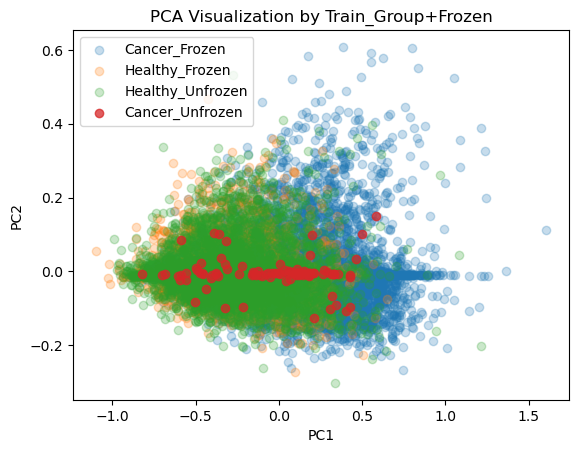

In [70]:
# PCA methods
pca_transform = PCA(n_components=10)

na_column_all = X_all_top.columns[X_all_top.isna().any()].tolist()
X_train_pca = pca_transform.fit_transform(X_train_top.drop(columns=na_column_all))
X_all_pca = pca_transform.transform(X_all_top.drop(columns=na_column_all))

# Visualize PCA results by train_group and frozen status
plt.figure()
# for label in set(CCSA_feature["Frozen_label"]):
#     plt.scatter(X_all_pca[CCSA_feature["Frozen_label"] == label, 0], X_all_pca[CCSA_feature["Frozen_label"] == label, 1], label=label, alpha=0.25)

plt.scatter(
    X_all_pca[CCSA_feature["Frozen_label"] == "Cancer_Frozen", 0],
    X_all_pca[CCSA_feature["Frozen_label"] == "Cancer_Frozen", 1],
    label="Cancer_Frozen",
    alpha=0.25,
)
plt.scatter(
    X_all_pca[CCSA_feature["Frozen_label"] == "Healthy_Frozen", 0],
    X_all_pca[CCSA_feature["Frozen_label"] == "Healthy_Frozen", 1],
    label="Healthy_Frozen",
    alpha=0.25,
)
plt.scatter(
    X_all_pca[CCSA_feature["Frozen_label"] == "Healthy_Unfrozen", 0],
    X_all_pca[CCSA_feature["Frozen_label"] == "Healthy_Unfrozen", 1],
    label="Healthy_Unfrozen",
    alpha=0.25,
)
plt.scatter(
    X_all_pca[CCSA_feature["Frozen_label"] == "Cancer_Unfrozen", 0],
    X_all_pca[CCSA_feature["Frozen_label"] == "Cancer_Unfrozen", 1],
    label="Cancer_Unfrozen",
    alpha=0.75,
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("PCA Visualization by Train_Group+Frozen")
plt.savefig(f"{output_path}/{feature_type}_PCA_CCSA.png", dpi=300)
plt.show()

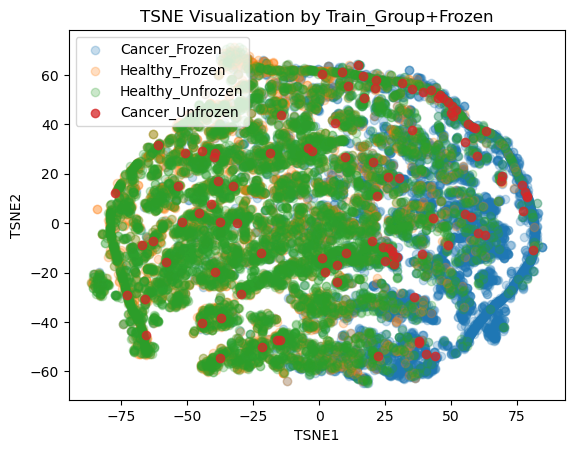

In [71]:
# TSNE method
tsne_transform = TSNE(
    n_components=2, perplexity=50, early_exaggeration=20, n_iter=1000, init="pca"
)

na_column_all = X_all_top.columns[X_all_top.isna().any()].tolist()
# X_train_tsne = tsne_transform.fit_transform(X_train_tensor.squeeze(1))
X_all_tsne = tsne_transform.fit_transform(X_all_top.drop(columns=na_column_all))

# Visualize PCA results by train_group and frozen status
plt.figure()
# for label in set(CCSA_feature["Frozen_label"]):
#     plt.scatter(X_all_pca[CCSA_feature["Frozen_label"] == label, 0], X_all_pca[CCSA_feature["Frozen_label"] == label, 1], label=label, alpha=0.25)
plt.scatter(
    X_all_tsne[CCSA_feature["Frozen_label"] == "Cancer_Frozen", 0],
    X_all_tsne[CCSA_feature["Frozen_label"] == "Cancer_Frozen", 1],
    label="Cancer_Frozen",
    alpha=0.25,
)
plt.scatter(
    X_all_tsne[CCSA_feature["Frozen_label"] == "Healthy_Frozen", 0],
    X_all_tsne[CCSA_feature["Frozen_label"] == "Healthy_Frozen", 1],
    label="Healthy_Frozen",
    alpha=0.25,
)
plt.scatter(
    X_all_tsne[CCSA_feature["Frozen_label"] == "Healthy_Unfrozen", 0],
    X_all_tsne[CCSA_feature["Frozen_label"] == "Healthy_Unfrozen", 1],
    label="Healthy_Unfrozen",
    alpha=0.25,
)
plt.scatter(
    X_all_tsne[CCSA_feature["Frozen_label"] == "Cancer_Unfrozen", 0],
    X_all_tsne[CCSA_feature["Frozen_label"] == "Cancer_Unfrozen", 1],
    label="Cancer_Unfrozen",
    alpha=0.75,
)

plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend()
plt.title("TSNE Visualization by Train_Group+Frozen")
plt.savefig(f"{output_path}/{feature_type}_TSNE_CCSA.png", dpi=300)
plt.show()

In [72]:
# #### 3D plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d")

# # Scatter plot for each group in 3D
# group_colors = {
#     "Healthy_Unfrozen": "blue",
#     # "Cancer_Frozen": "orange",
#     "Healthy_Frozen": "green",
#     "Cancer_Unfrozen": "red",
# }

# for label, color in group_colors.items():
#     ax.scatter(
#         X_all_tsne[CCSA_feature["Frozen_label"] == label, 0],
#         X_all_tsne[CCSA_feature["Frozen_label"] == label, 1],
#         X_all_tsne[CCSA_feature["Frozen_label"] == label, 2],
#         label=label,
#         alpha=0.25,
#         color=color,
#     )

# # Set labels and title
# ax.set_xlabel("TSNE1")
# ax.set_ylabel("TSNE2")
# ax.set_zlabel("TSNE3")
# plt.title("3D TSNE Visualization by Train_Group+Frozen")

# # Add a legend
# ax.legend()

# # Show plot
# plt.show()

/mnt/binf/eric/anaconda3/envs/Py310/lib/python3.10/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


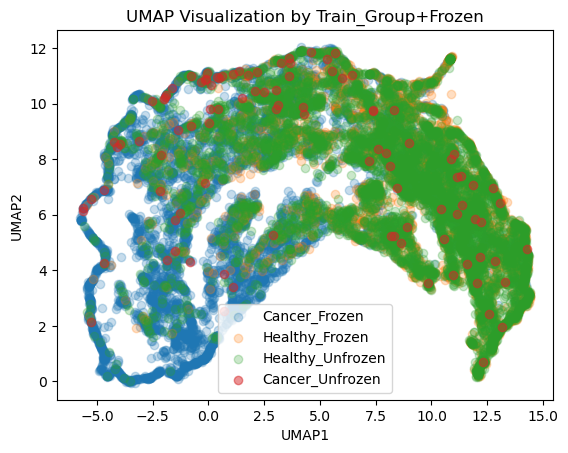

In [73]:
# umap
na_column_train = X_train_top.columns[X_all_top.isna().any()].tolist()

umap_transform = umap.UMAP(n_neighbors=10).fit(
    X_train_top.drop(columns=na_column_train)
)
X_all_umap = umap_transform.transform(X_all_top.drop(columns=na_column_train))

# Visualize PCA results by train_group and frozen status
plt.figure()
# for label in set(CCSA_feature["Frozen_label"]):
#     plt.scatter(X_all_pca[CCSA_feature["Frozen_label"] == label, 0], X_all_pca[CCSA_feature["Frozen_label"] == label, 1], label=label, alpha=0.25)
plt.scatter(
    X_all_umap[CCSA_feature["Frozen_label"] == "Cancer_Frozen", 0],
    X_all_umap[CCSA_feature["Frozen_label"] == "Cancer_Frozen", 1],
    label="Cancer_Frozen",
    alpha=0.25,
)
plt.scatter(
    X_all_umap[CCSA_feature["Frozen_label"] == "Healthy_Frozen", 0],
    X_all_umap[CCSA_feature["Frozen_label"] == "Healthy_Frozen", 1],
    label="Healthy_Frozen",
    alpha=0.25,
)
plt.scatter(
    X_all_umap[CCSA_feature["Frozen_label"] == "Healthy_Unfrozen", 0],
    X_all_umap[CCSA_feature["Frozen_label"] == "Healthy_Unfrozen", 1],
    label="Healthy_Unfrozen",
    alpha=0.25,
)
plt.scatter(
    X_all_umap[CCSA_feature["Frozen_label"] == "Cancer_Unfrozen", 0],
    X_all_umap[CCSA_feature["Frozen_label"] == "Cancer_Unfrozen", 1],
    label="Cancer_Unfrozen",
    alpha=0.5,
)

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend()
plt.title("UMAP Visualization by Train_Group+Frozen")
plt.savefig(f"{output_path}/{feature_type}_UMAP_CCSA.png", dpi=300)
plt.show()

In [74]:
# # MDS methods
# mds_transform = MDS(n_components=2)

# na_column = X_train_top.columns[X_train_top.isna().any()].tolist()
# X_train_mds = mds_transform.fit_transform(X_train_top.drop(columns=na_column))
# X_all_mds = mds_transform.transform(X_all_top.drop(columns=na_column))

# # Visualize mds results by train_group and frozen status
# plt.figure()
# # for label in set(CCSA_feature["Frozen_label"]):
# #     plt.scatter(X_all_mds[CCSA_feature["Frozen_label"] == label, 0], X_all_mds[CCSA_feature["Frozen_label"] == label, 1], label=label, alpha=0.25)
# plt.scatter(
#   X_all_mds[CCSA_feature["Frozen_label"] == "Healthy_Unfrozen", 0],
#   X_all_mds[CCSA_feature["Frozen_label"] == "Healthy_Unfrozen", 1],
#   label="Healthy_Unfrozen",
#   alpha=0.25,
# )
# plt.scatter(
#   X_all_mds[CCSA_feature["Frozen_label"] == "Cancer_Frozen", 0],
#   X_all_mds[CCSA_feature["Frozen_label"] == "Cancer_Frozen", 1],
#   label="Cancer_Frozen",
#   alpha=0.25,
# )
# plt.scatter(
#   X_all_mds[CCSA_feature["Frozen_label"] == "Healthy_Frozen", 0],
#   X_all_mds[CCSA_feature["Frozen_label"] == "Healthy_Frozen", 1],
#   label="Healthy_Frozen",
#   alpha=0.25,
# )
# plt.scatter(
#   X_all_mds[CCSA_feature["Frozen_label"] == "Cancer_Unfrozen", 0],
#   X_all_mds[CCSA_feature["Frozen_label"] == "Cancer_Unfrozen", 1],
#   label="Cancer_Unfrozen",
#   alpha=0.75,
# )

# plt.xlabel("MDS1")
# plt.ylabel("MDS2")
# plt.legend()
# plt.title("MDS Visualization by Train_Group+Frozen")
# plt.show()

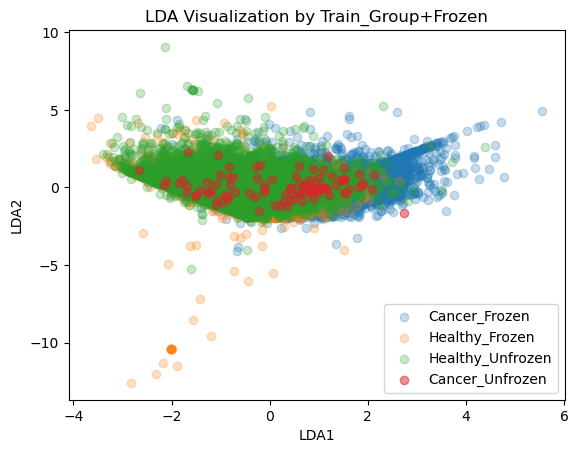

In [75]:
# LDA methods
lda_transform = LDA(n_components=2)

na_column_all = X_all_top.columns[X_all_top.isna().any()].tolist()
X_all_lda = lda_transform.fit_transform(
    X_all_top.drop(columns=na_column_all), frozen_all
)

# Visualize lda results by train_group and frozen status
plt.figure()
# for label in set(CCSA_feature["Frozen_label"]):
#     plt.scatter(X_all_lda[CCSA_feature["Frozen_label"] == label, 0], X_all_lda[CCSA_feature["Frozen_label"] == label, 1], label=label, alpha=0.25)


plt.scatter(
    X_all_lda[CCSA_feature["Frozen_label"] == "Cancer_Frozen", 0],
    X_all_lda[CCSA_feature["Frozen_label"] == "Cancer_Frozen", 1],
    label="Cancer_Frozen",
    alpha=0.25,
)
plt.scatter(
    X_all_lda[CCSA_feature["Frozen_label"] == "Healthy_Frozen", 0],
    X_all_lda[CCSA_feature["Frozen_label"] == "Healthy_Frozen", 1],
    label="Healthy_Frozen",
    alpha=0.25,
)
plt.scatter(
    X_all_lda[CCSA_feature["Frozen_label"] == "Healthy_Unfrozen", 0],
    X_all_lda[CCSA_feature["Frozen_label"] == "Healthy_Unfrozen", 1],
    label="Healthy_Unfrozen",
    alpha=0.25,
)
plt.scatter(
    X_all_lda[CCSA_feature["Frozen_label"] == "Cancer_Unfrozen", 0],
    X_all_lda[CCSA_feature["Frozen_label"] == "Cancer_Unfrozen", 1],
    label="Cancer_Unfrozen",
    alpha=0.5,
)

plt.xlabel("LDA1")
plt.ylabel("LDA2")
plt.legend()
plt.title("LDA Visualization by Train_Group+Frozen")
plt.savefig(f"{output_path}/{feature_type}_LDA_CCSA.png", dpi=300)
plt.show()

In [76]:
set(frozen_train)

{'Cancer_Frozen', 'Healthy_Frozen'}